In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import copy

import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import seaborn as sns

import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
preprocess = data_transforms['test'] = data_transforms['val']

preprocess = data_transforms['val']


In [28]:
copy_from = os.path.join(os.getcwd(), 'photoset_4500')
path_to_download = os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_7.csv')

df = pd.read_csv(path_to_download)

res = []
for i, row in df.iterrows():
    photo_path = os.path.join(copy_from, 'photo{0}.jpg'.format(i))
    
    #try:
    if os.path.exists(photo_path):
        input_image = Image.open(photo_path).convert('RGB')

        input_tensor = preprocess(input_image)
        input_batch = input_tensor.unsqueeze(0)


        with torch.no_grad():
            output = model(input_batch).squeeze()
        res.append(output.numpy())
    else:
        res.append(np.array([None]*512))

c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [4]:
resnet_df = pd.DataFrame(data=np.stack(res).astype(np.float), columns=[f'resnet_{i}' for i in range(512)])
data = np.concatenate([df[['Amount of subscribers', 'Amount of likes']].values, np.stack(res).astype(np.float)], axis=1)
_data = data[data[:, -1] == data[:, -1]] # dummy filtering
np.save(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet.npy'), _data)

NameError: name 'res' is not defined

In [6]:
_data = np.load(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet.npy'))

_data_trainval, _data_test = train_test_split(_data, test_size=0.1)


_data_train, _data_val = train_test_split(_data_trainval, test_size=0.1)

np.save(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_train.npy'), _data_train)
np.save(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_val.npy'), _data_val)
np.save(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_test.npy'), _data_test)

In [7]:
_data = {}
_data['train'] = np.load(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_train.npy'))
_data['val'] = np.load(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_val.npy'))
_data['test'] = np.load(os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_8_resnet__subscribers_likes_resnet_test.npy'), )


scaler = preprocessing.StandardScaler().fit(_data_train[:, :1])

def get_dataset(_data, scaler):
    _data[:, 1] /= _data[:, 0] + 1e-9
    _data[:, :1] = scaler.transform(_data[:, :1])
    _data = torch.tensor(_data).float()
    _dataset = torch.utils.data.TensorDataset(_data)
    return _dataset

dataloaders = {}
for key in _data:
    dataloaders[key] = torch.utils.data.DataLoader(get_dataset(_data[key], scaler), batch_size=5, shuffle=True)
    
    
# _data_train[:, :1] = scaler.transform(_data_train[:, :1])
# _data_test[:, :1] = scaler.transform(_data_test[:, :1])


# _data_train = torch.tensor(_data_train).float()
# train_dataset = torch.utils.data.TensorDataset(_data_train)

# # scaler = preprocessing.StandardScaler().fit(train_dataset[:, :2])

# _data_test = torch.tensor(_data_test).float()
# test_dataset = torch.utils.data.TensorDataset(_data_test)


# dataloaders = {
#     'train': torch.utils.data.DataLoader(train_dataset, batch_size=5),
#     'val': torch.utils.data.DataLoader(test_dataset, batch_size=5),
# }

class BaselineNet(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(512, hidden_size)
        self.fc2 = nn.Linear(hidden_size + 1, hidden_size + 1 // 2)
        self.fc3 = nn.Linear(hidden_size + 1 // 2, 1)
        
    def forward(self, resnet_features, user_features):
        # resnet_features B x 512
        # user_features B x 1
        x = self.fc1(resnet_features) # B x 20
        x = torch.cat([x, user_features], dim=1) # B x 21
        x = nn.functional.relu(x) # B x 21
        x = self.fc2(x) # B x 10
        x = nn.functional.relu(x) # B x 10
        x = self.fc3(x) # B x 1
        return x

if False:
    net = BaselineNet(20)
    batch = next(iter(dataloaders['train']))
    user_features, gt, resnet_features = batch[0][:, :1], batch[0][:, 1:2], batch[0][:, 2:]
    res = net(resnet_features, user_features)
    print(res)

    


In [8]:
from collections import defaultdict

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25, phases=('train', 'val', 'test')):
    since = time.time()
    
    history = defaultdict(list)
    

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in phases:
            
            if phase == 'train':
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_custom_metric = .0
            phase_len = 0

            for batch in dataloaders[phase]:
                
                user_features, gt, resnet_features = batch[0][:, :1], batch[0][:, 1:2], batch[0][:, 2:]
#                 print(user_features, gt)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(resnet_features, user_features)
                    loss = criterion(outputs, gt)
                    custom_metric = (torch.abs(1 - outputs.squeeze() / (gt + 0.000001).squeeze())).sum()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * user_features.size(0)
                running_custom_metric += custom_metric.item()
                phase_len += user_features.size(0)
                history[f'{phase}_running_loss'].append(loss.item() * user_features.size(0))
                history[f'{phase}_running_custom_metric'].append(custom_metric.item())
#                 print(running_loss, phase_len)
                
                
                
            history[f'{phase}_mean_epoch_loss'].append(running_loss / phase_len)
            history[f'{phase}_mean_epoch_custom_metric'].append(running_custom_metric / phase_len)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss

            print('{} Loss: {:.4f} Custom metric: {:.4f}'.format(
                phase, epoch_loss / phase_len, running_custom_metric / phase_len))

            if phase == 'val' and running_custom_metric / phase_len < best_acc:
                best_acc = running_custom_metric / phase_len
                best_model_wts = copy.deepcopy(model.state_dict())
                print(epoch, 'best weights update')

        print()

    time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     model.load_state_dict(best_model_wts)
    return model, history, best_model_wts

In [12]:
net = BaselineNet(20)
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.6)
optimizer = optim.Adam(net.parameters())
scheduler = lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.1)
loss = nn.MSELoss()

model, history, best_model_wts = train_model(
    net,
    loss,
    optimizer,
    scheduler,
    dataloaders,
    35
)

Epoch 0/34
----------
train Loss: 0.0202 Custom metric: 8.0774
val Loss: 0.0224 Custom metric: 15.4560
0 best weights update
test Loss: 0.0183 Custom metric: 11.0009

Epoch 1/34
----------
train Loss: 0.0183 Custom metric: 6.8573
val Loss: 0.0225 Custom metric: 5.5819
1 best weights update
test Loss: 0.0156 Custom metric: 4.7599

Epoch 2/34
----------
train Loss: 0.0173 Custom metric: 6.2954
val Loss: 0.0218 Custom metric: 6.9971
test Loss: 0.0149 Custom metric: 5.3392

Epoch 3/34
----------
train Loss: 0.0169 Custom metric: 6.7529
val Loss: 0.0216 Custom metric: 8.5764
test Loss: 0.0150 Custom metric: 5.9650

Epoch 4/34
----------
train Loss: 0.0167 Custom metric: 6.0934
val Loss: 0.0218 Custom metric: 6.5482
test Loss: 0.0150 Custom metric: 5.1215

Epoch 5/34
----------
train Loss: 0.0168 Custom metric: 6.0157
val Loss: 0.0218 Custom metric: 5.1658
5 best weights update
test Loss: 0.0149 Custom metric: 4.7465

Epoch 6/34
----------
train Loss: 0.0167 Custom metric: 5.6219
val Loss: 0

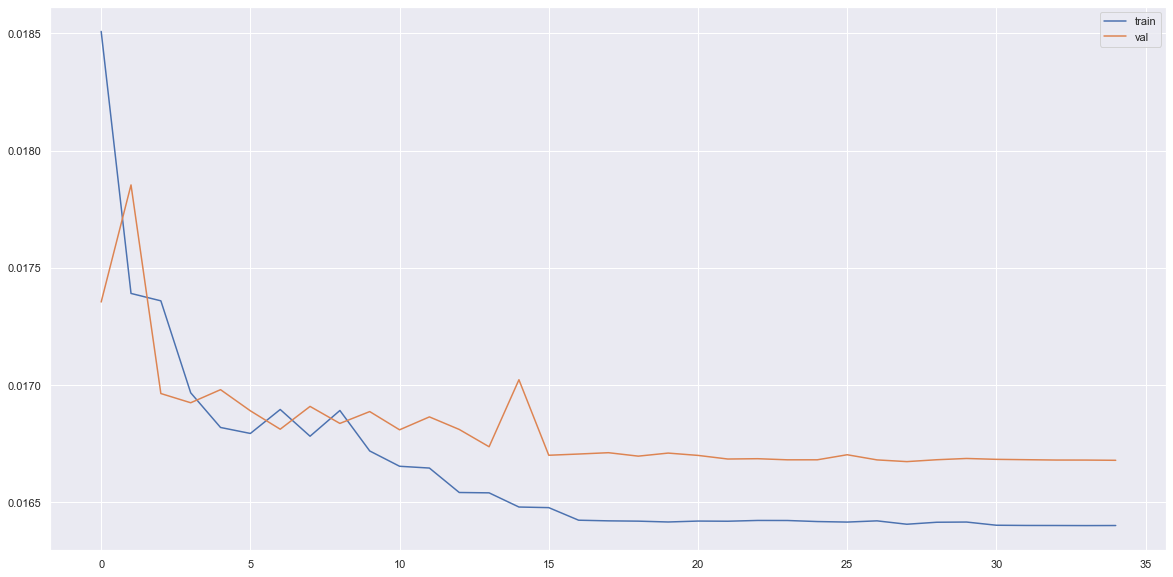

In [59]:
sns.set(rc={'figure.figsize':(20, 10)})
sns.lineplot(data = history['train_mean_epoch_loss'], label = 'train')
sns.lineplot(data = history['val_mean_epoch_loss'], label = 'val')

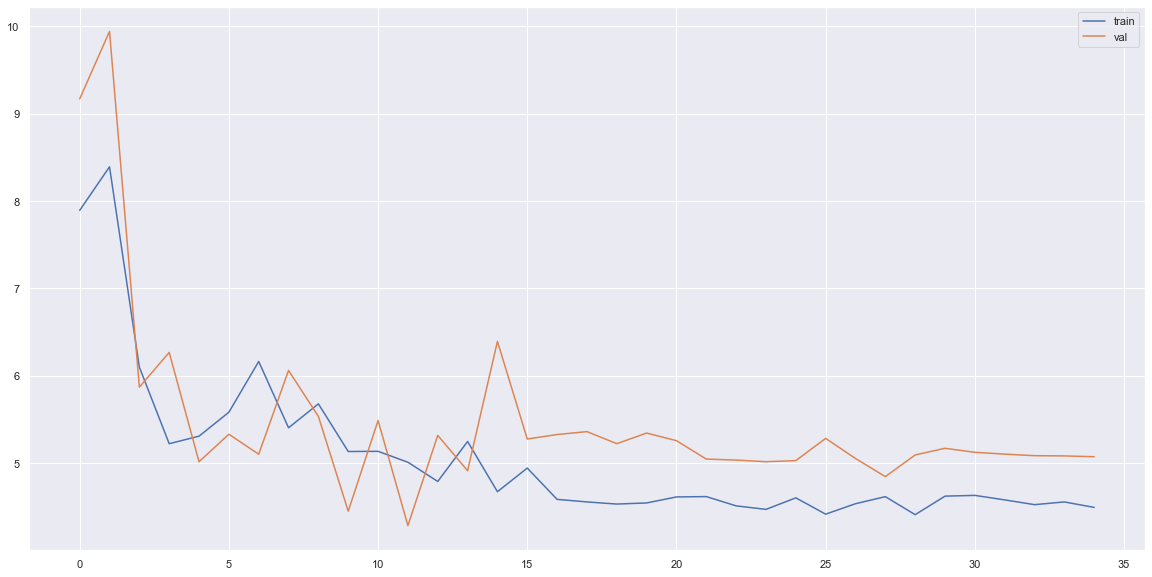

In [60]:
sns.lineplot(data = history['train_mean_epoch_custom_metric'], label = 'train')
sns.lineplot(data = history['val_mean_epoch_custom_metric'], label = 'val')

In [47]:
_, history, _ = train_model(
    net,
    loss,
    optimizer,
    scheduler,
    dataloaders,
    1,
    ['test'])

Epoch 0/0
----------
test Loss: 0.0191 Custom metric: 5.2628



In [48]:
history

defaultdict(list,
            {'test_running_loss': [0.010889249388128519,
              0.7070839405059814,
              0.02346085850149393,
              0.018584707286208868,
              0.030637443996965885,
              0.07420681416988373,
              0.033581145107746124,
              0.1319679617881775,
              0.04360106308013201,
              0.3098607435822487,
              0.013271580683067441,
              0.015325143467634916,
              0.2378075197339058,
              0.02705950988456607,
              0.031825932674109936,
              0.41823845356702805,
              0.0313556264154613,
              0.017331389244645834,
              0.04016744904220104,
              0.027836484368890524,
              0.024484568275511265,
              0.012114692945033312,
              0.01261169440113008,
              0.1917264424264431,
              0.03262782469391823,
              0.06910908035933971,
              0.03156181890517473,
           

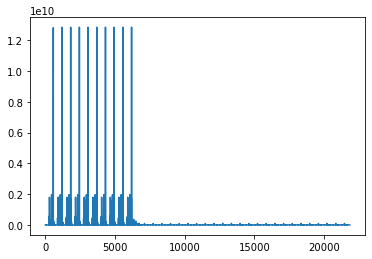

In [19]:
plt.plot(history['train_running_loss'])

In [74]:
_data_test[:, 1]

tensor([-1.6125e-01, -1.3821e-01,  6.5873e-03, -1.6113e-01,  3.1672e-01,
        -1.5945e-01, -1.5589e-01,  3.9117e+00, -1.4767e-01, -1.5996e-01,
        -1.2221e-01, -1.0754e-01, -9.6515e-02,  3.6000e-02, -1.5792e-01,
        -7.5081e-02, -1.5143e-01, -1.3375e-01, -1.5366e-01,  9.1616e-01,
        -7.9618e-02, -1.5448e-01, -1.0332e-01, -1.6465e-01, -1.3234e-01,
        -1.0473e-01, -7.9657e-02, -7.1717e-02, -1.5874e-01, -8.7793e-02,
        -1.6222e-01, -8.6033e-02, -6.3816e-02, -1.0590e-01, -1.3872e-01,
        -1.4924e-01, -9.8314e-02, -1.6238e-01, -1.6309e-01, -1.1744e-01,
        -1.1505e-01, -1.5737e-01, -9.1753e-03, -1.5694e-01, -1.4693e-01,
        -1.6101e-01, -1.5483e-01, -1.5331e-01, -1.6324e-01, -1.2491e-01,
        -1.5949e-01, -1.5378e-01, -1.4983e-01, -1.4635e-01, -1.2378e-01,
        -1.3148e-01, -1.6211e-01,  1.4645e-02, -1.6434e-01, -1.5722e-01,
        -1.2198e-01, -1.6215e-01, -5.1730e-02, -1.2839e-01, -1.5659e-01,
        -1.6352e-01, -1.5906e-01, -1.6512e-01, -1.1

In [93]:
device = torch.device('cpu')

In [9]:
input_image = Image.open('photo916.jpg')

model_conv = models.resnet18(pretrained=True)
model_conv = nn.Sequential(*list(model_conv.children())[:-1])

model_conv.eval
print(model_conv)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [10]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model_conv(input_batch)  

In [5]:
output.shape

torch.Size([1, 512, 1, 1])

In [88]:
input_batch.shape

torch.Size([1, 3, 224, 224])

In [13]:
subscribers = 100
resnet_out = output[:, :, 0, 0]
scaled_subscribers = scaler.transform(np.array([subscribers]).reshape(-1,1))
with torch.no_grad():
    res = model(torch.tensor(resnet_out).float(), torch.tensor(scaled_subscribers).float())
    print(res[0, 0])

tensor(0.1105)


c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [66]:
resnet_out = output[:, :, 0, 0]
resnet_out.shape

torch.Size([1, 512])

In [67]:
subscribers = 100
with torch.no_grad():
    res = model(torch.tensor(resnet_out).float(), torch.tensor(scaled_subscribers).float())
    print(res[0, 0])

tensor(0.1107)


c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
subscribers = 100
resnet_out = output[:, :, 0, 0]
scaled_subscribers = scaler.transform(np.array([subscribers]).reshape(-1,1))
with torch.no_grad():
    res = model(torch.tensor(resnet_out).float(), torch.tensor(scaled_subscribers).float())
    print(res[0, 0])

tensor(0.1105)


c:\users\gafed\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


In [17]:
torch.tensor(scaled_subscribers).float()

tensor([[-0.1620]])

In [19]:
torch.tensor(scaled_subscribers).shape

torch.Size([1, 1])

In [68]:
#torch.save(model.state_dict(), os.path.join(os.getcwd(), 'models', 'regression.pt'))

In [15]:
from torch.utils.mobile_optimizer import optimize_for_mobile

In [69]:
#torch.save(model_conv.state_dict(), os.path.join(os.getcwd(), 'models', 'resnet_v1.pt'))

In [9]:
model_conv.qconfig = torch.quantization.get_default_qconfig('qnnpack')

torch.quantization.prepare(model_conv, inplace = True)

model_conv = torch.quantization.convert(model_conv, inplace=True)

In [17]:
torchscript_model = torch.jit.script(model_conv)

torchscript_model_optim = optimize_for_mobile(torchscript_model)

torch.jit.save(torchscript_model_optim, "resnet_v4.pt")

In [16]:
torchscript_model = torch.jit.script(model)

torchscript_model_optim = optimize_for_mobile(torchscript_model)

torch.jit.save(torchscript_model_optim, "regression_v2.pt")

In [91]:
input_image = Image.open('photo916.jpg')

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

script_model = torch.jit.trace(model_conv, input_batch)
script_model.save("resnet_v1.pt")

RuntimeError: Could not get name of python class object

In [45]:
resnet_out

tensor([[0.9480, 0.9440, 0.8928, 1.0311, 0.9375, 0.8997, 0.9461, 1.2372, 0.8942,
         0.9717, 0.8879, 0.9046, 0.8710, 0.8523, 0.9597, 0.9752, 0.8911, 1.3364,
         0.9511, 0.8552, 0.9348, 1.0872, 0.9829, 0.9747, 0.8746, 0.9333, 0.9474,
         0.9706, 0.7698, 0.9099, 0.9441, 0.8612, 0.8758, 0.8315, 1.0007, 0.8798,
         1.0292, 0.9619, 0.8031, 0.9379, 0.9497, 0.8255, 0.8731, 0.9848, 0.8537,
         0.8980, 0.9007, 1.1624, 1.0223, 0.8397, 1.0355, 0.9502, 0.8565, 0.8805,
         0.9324, 0.9247, 1.1240, 0.9663, 1.0122, 0.9349, 0.8652, 1.0521, 0.9285,
         0.9065, 0.9178, 1.1087, 0.8142, 0.8613, 1.0269, 0.8341, 0.8735, 0.8200,
         0.8662, 0.8235, 0.9496, 0.8826, 0.9231, 0.8697, 0.8914, 0.9389, 0.9316,
         1.0070, 1.0021, 1.1816, 0.8788, 0.9136, 0.9024, 0.8991, 0.9175, 0.9451,
         0.7541, 0.9180, 0.9423, 0.9275, 0.8820, 0.8929, 0.9193, 0.8972, 0.9125,
         0.8926, 0.9291, 1.0407, 1.0064, 1.0428, 0.9806, 0.8666, 1.0076, 0.8710,
         0.8475, 0.9467, 0.8

In [50]:
output[:,:,0, 0]

tensor([[0.9480, 0.9440, 0.8928, 1.0311, 0.9375, 0.8997, 0.9461, 1.2372, 0.8942,
         0.9717, 0.8879, 0.9046, 0.8710, 0.8523, 0.9597, 0.9752, 0.8911, 1.3364,
         0.9511, 0.8552, 0.9348, 1.0872, 0.9829, 0.9747, 0.8746, 0.9333, 0.9474,
         0.9706, 0.7698, 0.9099, 0.9441, 0.8612, 0.8758, 0.8315, 1.0007, 0.8798,
         1.0292, 0.9619, 0.8031, 0.9379, 0.9497, 0.8255, 0.8731, 0.9848, 0.8537,
         0.8980, 0.9007, 1.1624, 1.0223, 0.8397, 1.0355, 0.9502, 0.8565, 0.8805,
         0.9324, 0.9247, 1.1240, 0.9663, 1.0122, 0.9349, 0.8652, 1.0521, 0.9285,
         0.9065, 0.9178, 1.1087, 0.8142, 0.8613, 1.0269, 0.8341, 0.8735, 0.8200,
         0.8662, 0.8235, 0.9496, 0.8826, 0.9231, 0.8697, 0.8914, 0.9389, 0.9316,
         1.0070, 1.0021, 1.1816, 0.8788, 0.9136, 0.9024, 0.8991, 0.9175, 0.9451,
         0.7541, 0.9180, 0.9423, 0.9275, 0.8820, 0.8929, 0.9193, 0.8972, 0.9125,
         0.8926, 0.9291, 1.0407, 1.0064, 1.0428, 0.9806, 0.8666, 1.0076, 0.8710,
         0.8475, 0.9467, 0.8

In [59]:
list(model_conv.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [84]:
df

,Picture URL,Amount of likes,Author name,Amount of subscribers,Post tags,Post date,Download URL,Marker,Ratio,Class
0,https://www.instagram.com/p/CNzI3m9MNxO/,165,romina_stanescu,1397,"['#morningselfie', '#morningmood', '#selfie']",2021-04-18T07:32:21.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.118110,1.0
1,https://www.instagram.com/p/CNzKR83HAvI/,1217,yeonions,299936,"['#fromo', '#남자스니커즈', '#여자스니커즈', '#화이트스니커즈', '...",2021-04-18T07:44:42.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.004058,0.0
2,https://www.instagram.com/p/CNzCpoGn1_U/,1441,hyo._.jin23,63119,"['#네이밍미', '#올리비엣스퀘어드레스']",2021-04-18T06:38:01.000Z,https://scontent-arn2-2.cdninstagram.com/v/t51...,0,0.022830,0.0
3,https://www.instagram.com/p/CNzNd_MJIU6/,367,out___and___outer,10961,"['#travel', '#модельмосква', '#модельдубай', '...",2021-04-18T08:12:33.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.033482,0.0
4,https://www.instagram.com/p/CNzOicxHVOT/,1479,all_zero._.k,104242,[],2021-04-18T08:21:54.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.014188,0.0
...,...,...,...,...,...,...,...,...,...,...
3854,https://www.instagram.com/p/CN2IA8Jnr4C/,828,dislav_v,8403,"['#in', '#instagram', '#insta', '#lol', '#1', ...",2021-04-19T11:22:37.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.098536,1.0
3855,https://www.instagram.com/p/CN2IAvtFWZW/,31,joshuabravo,765,"['#mensfashion', '#fashion', '#style', '#mensw...",2021-04-19T11:22:35.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.040523,0.0
3856,https://www.instagram.com/p/CN2IAYisu4A/,38,mala.mi.trenuje,1411,"['#rozRUSZAMY', '#polishgirl', '#fitgirl', '#f...",2021-04-19T11:22:32.000Z,https://scontent-arn2-1.cdninstagram.com/v/t51...,0,0.026931,0.0
3857,https://www.instagram.com/p/CN2IAS-jrh-/,33,tushargedar,360,"['#likes', '#like', '#follow', '#likeforlikes'...",2021-04-19T11:22:32.000Z,https://scontent-arn2-2.cdninstagram.com/v/t51...,0,0.091667,1.0


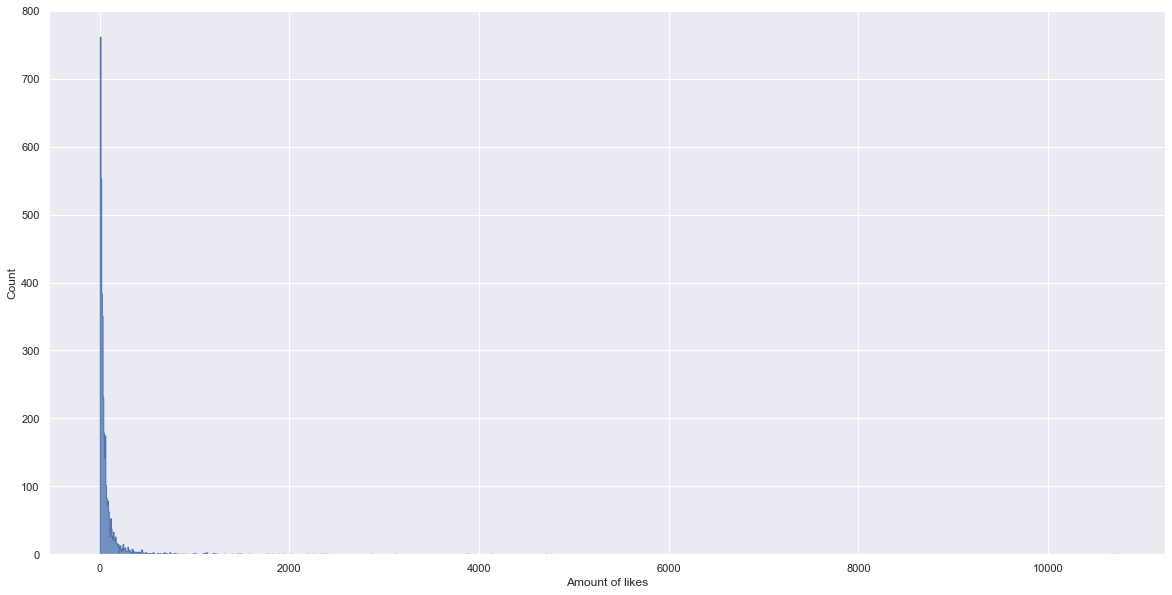

In [126]:
sns.set(rc={'figure.figsize':(20, 10)})
sns_plot = sns.histplot(data=df['Amount of likes'], element="step")

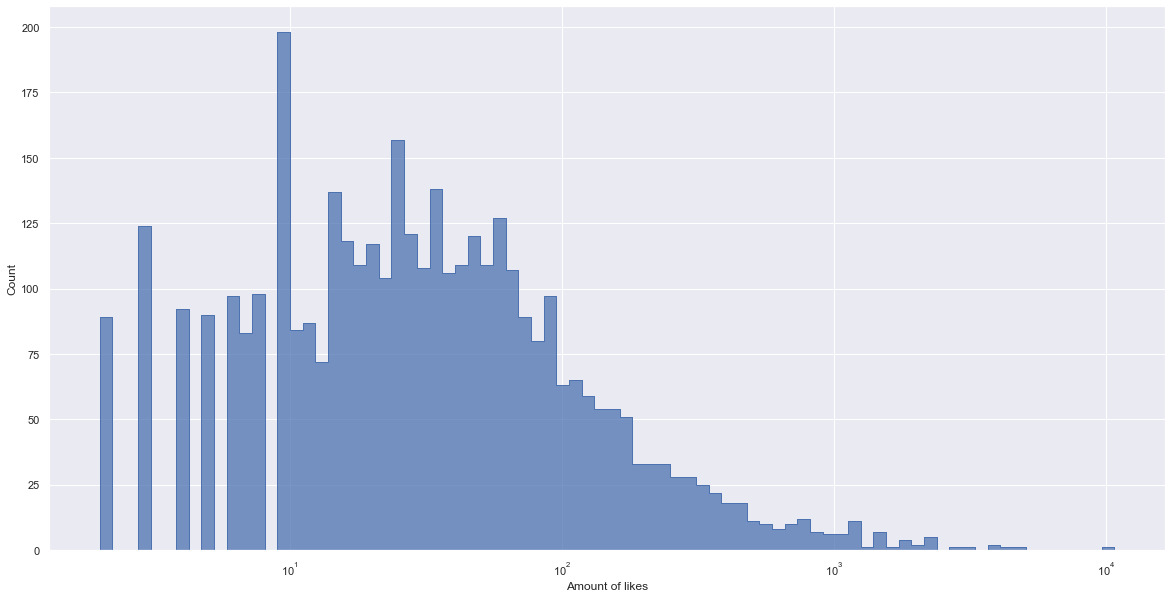

In [127]:
sns_plot = sns.histplot(data=df['Amount of likes'], element="step", bins=80, log_scale=True)

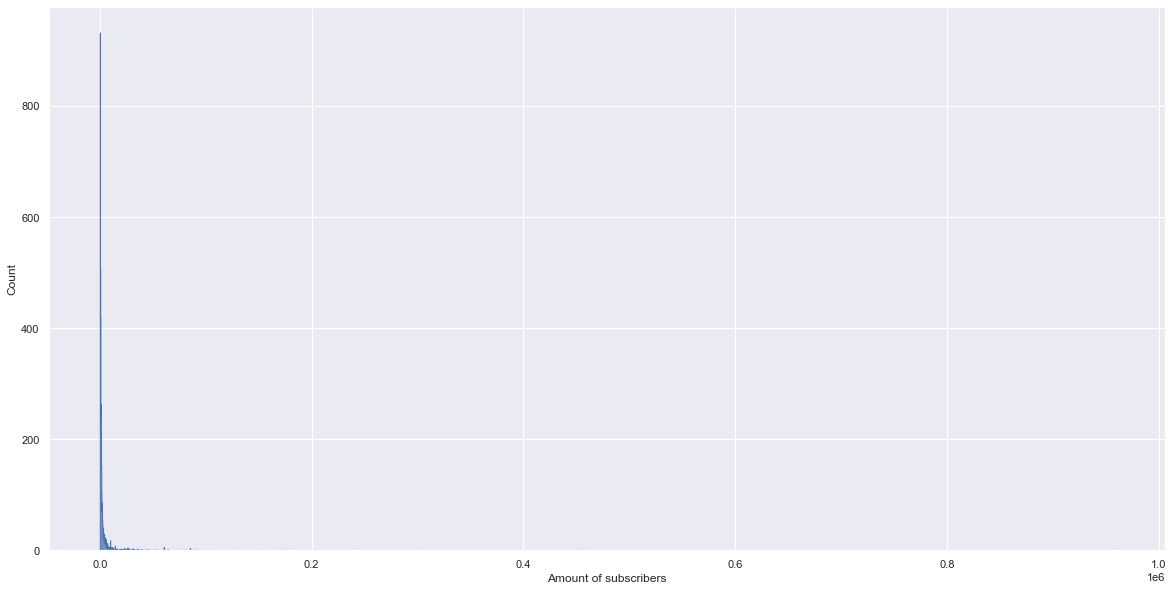

In [128]:
sns_plot = sns.histplot(data=df['Amount of subscribers'], element="step")


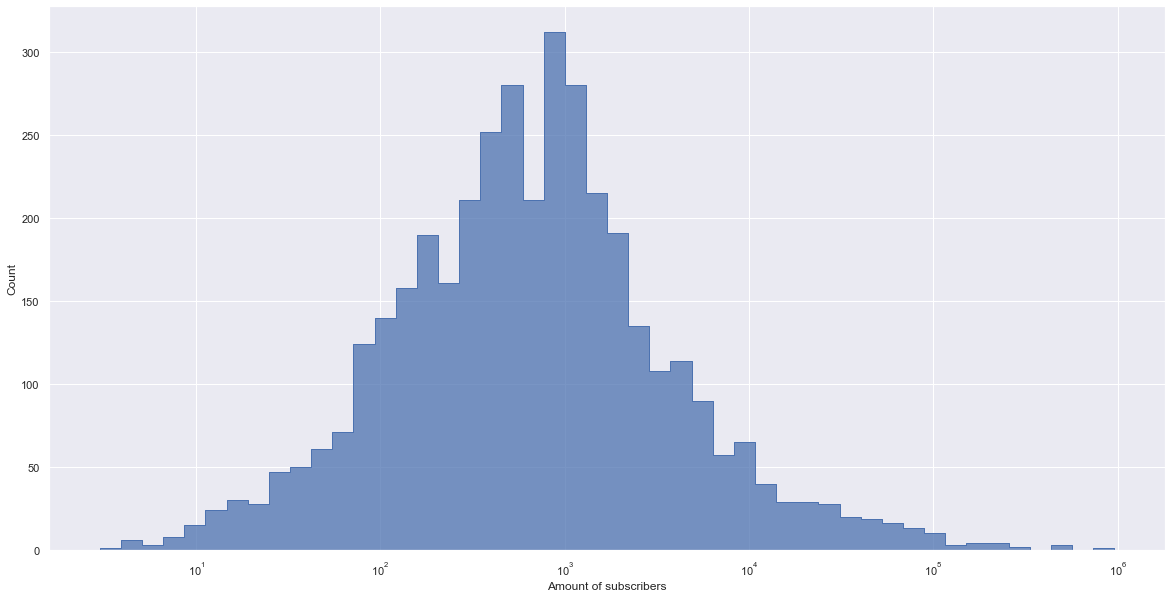

In [129]:
sns_plot = sns.histplot(data=df['Amount of subscribers'], element="step", log_scale=True)

In [50]:
path_to_download = os.path.join(os.getcwd(), 'data', 'photos_4500(3859)_v_7.csv')

df = pd.read_csv(path_to_download)

In [24]:
print(scaler.mean_)

[3915.875]


In [26]:
res[0, 0].float()

tensor(0.1105)

In [34]:
q = scaler.inverse_transform(res.data.tolist()[0][0])
q

ValueError: non-broadcastable output operand with shape () doesn't match the broadcast shape (1,)

In [33]:
res.data.tolist()[0][0]

0.11051233112812042

In [37]:
scaler.mean_

array([3915.875])

In [38]:
scaler.scale_

array([23552.26355037])

In [44]:
means = scaler.mean_ 
vars = scaler.var_ 
means

array([3915.875])

In [40]:
def scale_data(array, means = means, stds = vars ** 0.5):
    return (array - means) / stds

scale_new_data = scale_data(100)

In [41]:
scale_new_data

array([-0.16201734])

In [42]:
stds = scaler.var_ ** 0.5
stds

array([23552.26355037])

In [56]:
(200 - 3915.875) / 23552.26355037

-0.1577714597177911

In [46]:
qq = scaler.inverse_transform(scale_new_data)
qq

array([100.])

In [53]:
def custom_inverse_transform(scaled_value, means = 3915.875, stds = 23552.26355037):
    result = scaled_value * stds + means
    return result

In [55]:
custom_inverse_transform(0.1107)

6523.110575025959